<a href="https://colab.research.google.com/github/danielvijill/radion-24/blob/main/S_NGC5257_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NRAO NINE 2024

---



#Tutorial de análisis de datos de NGC5257

por [Daniel Argueta Vijil](https://astrohn.wixsite.com/danielvijil)$^1$ y [Alejandro Saravia](https://astronomy.as.virginia.edu/alejandro-saravia)$^2$

$^1$*Universidad Nacional Autónoma de Honduras, Tegucigalpa, Honduras*

$^2$*University of Virginia, Charlottesville VA, USA*


## Importar paquetes de Python

En este tutorial, utilizaremos las siguientes bibliotecas:

* [Astropy](https://learn.astropy.org/) (versión 5.3): utilidades astronómicas básicas
* [Pyregion](https://pyregion.readthedocs.io/en/latest/): para analizar archivos de regiones ds9
* [Photutils](https://photutils.readthedocs.io/en/stable/): para realizar fotometría en imágenes
* [Regions](https://pypi.org/project/regions/): otro paquete para regiones
* [Scipy](https://docs.scipy.org/doc/scipy/): herramientas científicas básicas
* [Aplpy](https://aplpy.readthedocs.io/en/stable/): para gráficos e imágenes de calidad

En caso de que esté utilizando collab, ejecute la celda a continuación para instalar los paquetes. Si los usa localmente, asegúrese de que las versiones de los paquetes sean correctas para evitar enfrentamientos con otros paquetes.



In [ ]:
%%capture
!pip install astropy==5.3;
!pip install pyregion;
!pip install photutils;
!pip install regions;
!pip install scipy;
!pip install aplpy;

In [ ]:
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
import pyregion
from astropy.coordinates import Angle
from astropy import units as u
from astropy.stats import SigmaClip
from photutils.background import StdBackgroundRMS
from regions import Regions
from pyregion import get_mask
import aplpy
import pandas as pd

Si se usa en Google Drive, esta celda monta la unidad para acceder a los archivos en su unidad.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
pathd = '/content/drive/MyDrive/Imaging Codes/'

Mounted at /content/drive


## Trabajando con archivos FITS

The FITS or [Flexible Image Transport System](https://fits.gsfc.nasa.gov/standard40/fits_standard40aa-le.pdf) is a standarized file format (which was largely developed by NRAO scientists) used for storage, transmitting and analyzing astronomical data. It consists of information presented in the form of Header Data Units (HDUs) and a header which contains keywords to describe the data in the HDU.

---
El FITS o [Sistema de transporte flexible de imágenes](https://fits.gsfc.nasa.gov/standard40/fits_standard40aa-le.pdf) por sus siglas en inglés, es un formato de archivo estandarizado (desarrollado en gran medida por científicos del NRAO) que se utiliza para almacenar, transmitir y analizar datos astronómicos. Consiste en información presentada en forma de unidades de datos de encabezado (HDU, por sus siglas en inglés) y un encabezado que contiene palabras clave para describir los datos en la HDU.

In [ ]:
image_file = pathd+'Galaxyfits/NGC5257_s_concat_uvt_dot75asec_rbeam1asec_csdot1.pbcor_hcorr.fits'

Podemos crear un gráfico aplpy ​​del archivo fits usando la clase `aplpy.FITSFigure`

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'.
INFO:astropy:Auto-setting vmin to -8.149e-05
INFO:astropy:Auto-setting vmax to  3.235e-04


INFO: Auto-setting vmin to -8.149e-05 [aplpy.core]
INFO: Auto-setting vmax to  3.235e-04 [aplpy.core]


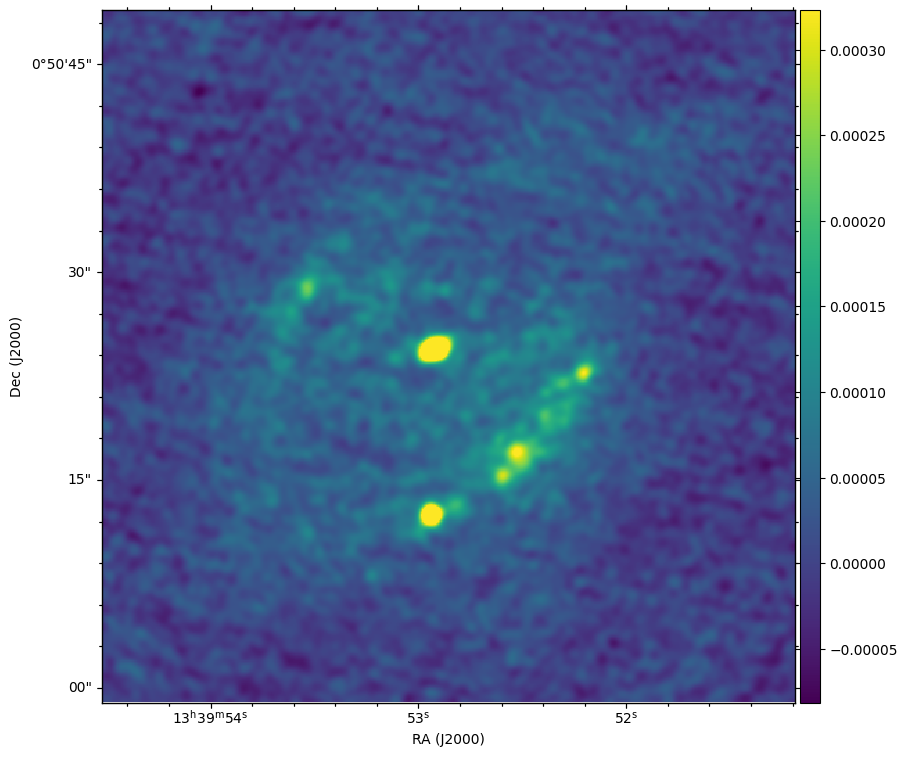

In [ ]:
sDi=aplpy.FITSFigure(image_file)
sDi.show_colorscale()
sDi.add_colorbar()

Comprobando el tipo de dato de `sDi`

In [ ]:
sDi

También podemos cargar la imagen utilizando la función `fits.open` que corresponde al paquete astropy

In [ ]:
image = fits.open(image_file)[0]
image

Y podemos extraer los datos de la imagen, que se mostrará como una matriz bidimensional de píxeles con diferentes valores de luminosidad.

In [ ]:
data = image.data
data

array([[ 8.26412725e-06,  1.11680338e-05,  1.26492369e-05, ...,
        -1.72429845e-05, -1.93974975e-05, -2.05095348e-05],
       [ 9.60668785e-06,  1.16774090e-05,  1.24986382e-05, ...,
        -1.34218863e-05, -1.55398520e-05, -1.68728329e-05],
       [ 9.51097627e-06,  1.08473023e-05,  1.12185162e-05, ...,
        -9.66556217e-06, -1.15705325e-05, -1.29631226e-05],
       ...,
       [-1.76731373e-05, -1.96667279e-05, -2.22559920e-05, ...,
        -1.09307339e-05, -1.17784193e-05, -1.12150310e-05],
       [-1.63994009e-05, -1.73223671e-05, -1.93626838e-05, ...,
        -9.35070511e-06, -8.95358426e-06, -7.01617500e-06],
       [-1.33105677e-05, -1.31605584e-05, -1.46572456e-05, ...,
        -8.54498649e-06, -6.71585485e-06, -3.33423918e-06]], dtype='>f4')

In [ ]:
data.sum()

5.0380697

Finalmente podemos echar un vistazo al encabezado, que proporciona información más útil sobre el archivo.

In [ ]:
header= image.header
# header

##Caracterización del ruido

Para las regiones importadas podemos calcular el ruido promedio, esto nos ayuda a diferenciar entre la emisión que proviene positivamente de la fuente y el ruido causado por el instrumento, la turbulencia atmosférica y muchos otros factores.

In [ ]:
# from astropy.units.cgs import K

vla_image = fits.getdata(image_file)

region_file = pathd + 'Regions/Regions.reg'
region = pyregion.open(region_file)
region

[Shape : circle ( Number(64.194444),Number(169.75),Number(28.958752) ),
 Shape : circle ( Number(76.694444),Number(91.972222),Number(29.84424) ),
 Shape : circle ( Number(152.38889),Number(78.083333),Number(29.958323) ),
 Shape : circle ( Number(345.44444),Number(433.63889),Number(28.258105) ),
 Shape : circle ( Number(422.52778),Number(389.19444),Number(30.302228) ),
 Shape : circle ( Number(425.30556),Number(294.75),Number(30.097001) )]

In [ ]:
  rms_values = []
  for K in range(len(region)):
    region = pyregion.open(region_file)
    m=len(region)
    del region[0:K]
    del region[1:m]

    mask = region.get_mask(shape=(vla_image.shape[0],vla_image.shape[1]),header=header)
    #mask = get_mask(region,data)
    maskdata= np.multiply(vla_image,mask)
    N=len(maskdata[maskdata!=0])
    rms_values.append(np.sqrt(np.sum(maskdata**2)/N))
  avg_rms = np.mean(rms_values)
  avg_rms

2.464470843479804e-05

In [ ]:
#maskdata= np.multiply(vla_image,mask[0])
#maskdata[maskdata!=0]
mask[1][mask[1]==True]
mask.shape

(500, 500)

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'.


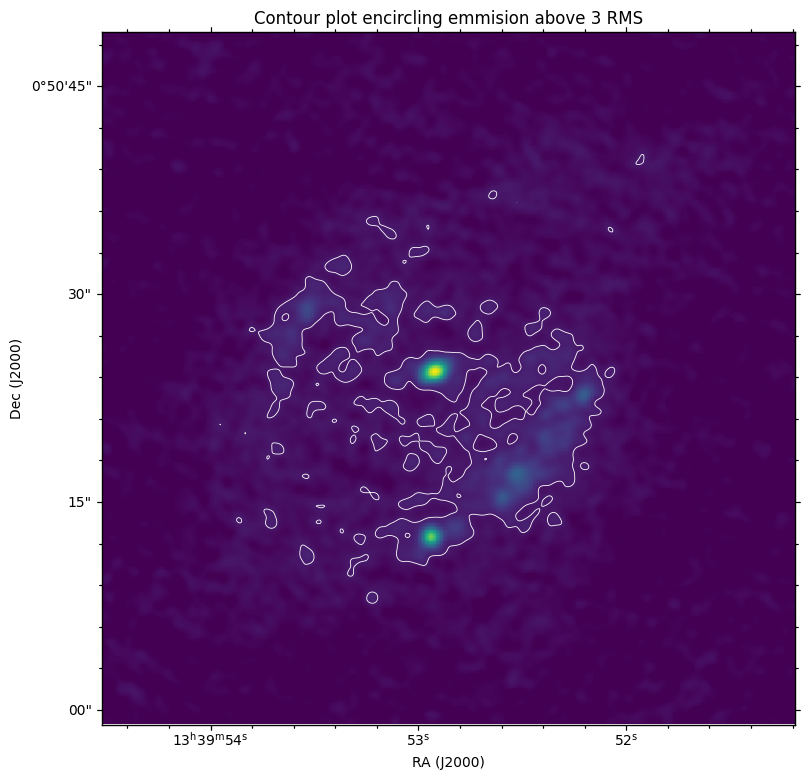

In [ ]:
fig = aplpy.FITSFigure(image_file)
fig.show_colorscale(vmin=0, vmax=np.max(vla_image), stretch='linear')
fig.show_contour(data=vla_image, levels=[3*avg_rms], colors=['white'], linewidths=0.6)
fig.set_title('Contour plot encircling emmision above 3 RMS')

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'.


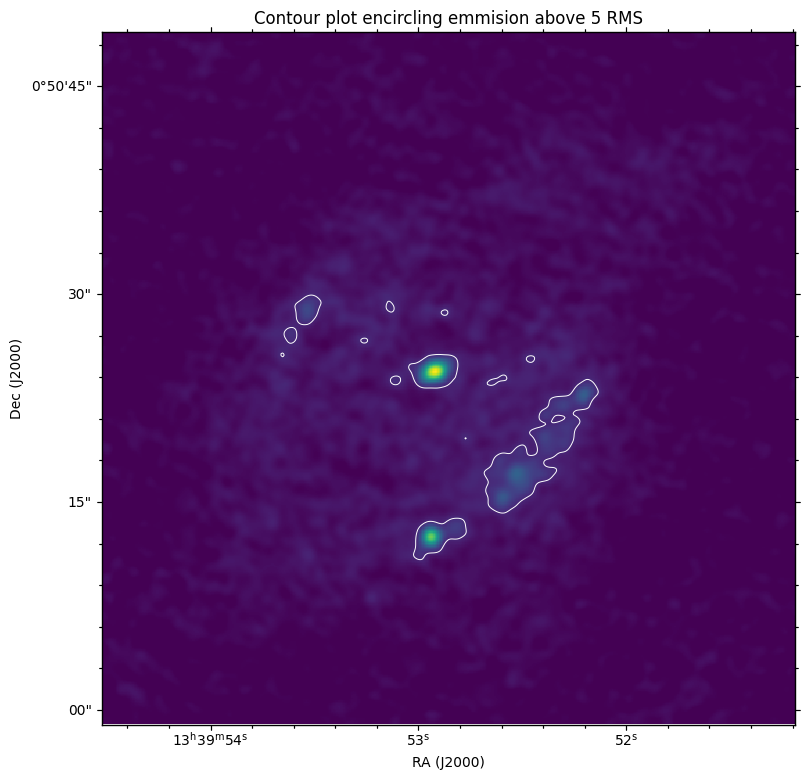

In [ ]:
fig = aplpy.FITSFigure(image_file)
fig.show_colorscale(vmin=0, vmax=np.max(vla_image), stretch='linear')
fig.show_contour(data=vla_image, levels=[5*avg_rms], colors=['white'], linewidths=0.7)
fig.set_title('Contour plot encircling emmision above 5 RMS')

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'.


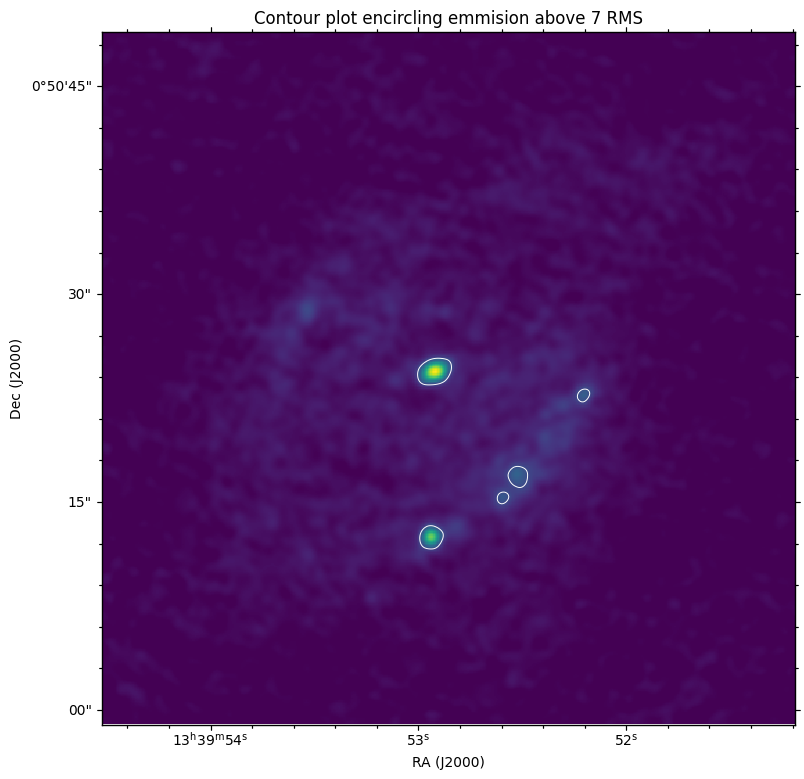

In [ ]:
fig = aplpy.FITSFigure(image_file)
fig.show_colorscale(vmin=0, vmax=np.max(vla_image), stretch='linear')
fig.show_contour(data=vla_image, levels=[10*avg_rms], colors=['white'], linewidths=0.7)
fig.set_title('Contour plot encircling emmision above 7 RMS')

##Fotometría

La fotometría se refiere al proceso de medir la intensidad o el brillo de una fuente mediante la captura de la radiación proveniente de la fuente.

In [ ]:
# bmaj, bmin and cdelt1 from the header
bmaj_deg = header['BMAJ']
bmin_deg = header['BMIN']
pixel_size_deg = header['CDELT1']

# Area of the beam in square degrees
area_deg2 = np.pi * bmaj_deg * bmin_deg / (4 * np.log(2))

# Area from square degrees to square pixels
pixel_area_deg2 = pixel_size_deg**2
area_pixels = area_deg2 / pixel_area_deg2

print("Area of the beam in pixels:", area_pixels)

Area of the beam in pixels: 113.30900354567986


In [ ]:
# Significant pixels are the ones with emission above 3-sigma (3 times the rms)
significant_pixels = vla_image[vla_image > 3 * avg_rms]

# Total emission in Jy by summing the significant pixels
total_emission_jy = np.sum(significant_pixels)

print("Total emission of the galaxy in Jy:", total_emission_jy)


Total emission of the galaxy in Jy: 2.295945


Calcular luminosidades como forma de medir cuánta energía por unidad de tiempo llega a un detector también es un ejercicio útil en astronomía, este cálculo depende de muchas variables:

In [ ]:
distance_parsecs=98e6

distance_cm= distance_parsecs*3.086e18

total_emission_erg= (total_emission_jy/area_pixels)*1e-23

solarluminosity= 3.827e33
total_luminosity_solar= total_emission_erg*4*np.pi*distance_cm**2/solarluminosity

print("Total luminosity in solar luminosities:",total_luminosity_solar)

Total luminosity in solar luminosities: 6.085446421856573e-05


In [ ]:
#total_emission_erg
total_emission_jy/area_pixels

0.020262687494178942

## Trabajando con cubos de datos

Un cubo de datos es un conjunto multidimensional de datos. En este caso, un conjunto tridimensional que contiene información espacial (ascensión recta y declinación galáctica) en dos de sus ejes e información espectral en el tercero. Esto nos permite visualizar la emisión a diferentes frecuencias proveniente de un único objeto.

Para trabajar con un cubo de datos, primero leemos el cubo y extraemos el encabezado y los datos de él.

In [ ]:
image2= fits.open('/content/drive/MyDrive/Imaging Codes/Galaxyfits/NGC_5257_cube_1arcsec_inregion.pbcor_hcorr.fits')[0]
image2

#data and header
cube_data = image2.data
cube_header = image2.header

Para comprender las dimensiones del cubo, podemos imprimir la forma del cubo de datos que se mostrará en píxeles.

In [ ]:
print(cube_data.shape)  # (n_channels, n_y_pixels, n_x_pixels)

n_channels = cube_header['NAXIS3']
n_y_pixels = cube_header['NAXIS2']
n_x_pixels = cube_header['NAXIS1']

(450, 500, 500)


Imprimiendo el header completo



In [ ]:
print(cube_header)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -32 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                  500                                                  NAXIS2  =                  500                                                  NAXIS3  =                  450                                                  BMAJ    =   0.0002777777777778                                                  BMIN    =   0.0002777777777778                                                  BPA     =                  0.0                                                  BTYPE   = 'Intensity'                                                           OBJECT  = 'NGC_5257'                                                            BUNIT   = 'Jy/beam '                                                            RADESYS = 'ICRS    '                    

Comprobando los datos en el cubo

In [ ]:
cube_data[1,:,:]

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype='>f4')

In [ ]:
V_d        = (1-cube_header['CRVAL3']/cube_header['RESTFRQ'])*2.99999e5                                                   #converts central freq to velocity
V_u        = (1-(cube_header['CRVAL3']+cube_header['CDELT3']*cube_header['NAXIS3'])/cube_header['RESTFRQ'])*2.99999e5     # calculates the lower frequency
deltaV     = (V_u-V_d)/cube_header['NAXIS3']

In [ ]:
V_d, V_u, deltaV

(6104.20259472077, 7455.132677162913, 3.002066849871428)

Podemos visualizar los canales del cubo de datos simplemente cambiando el parámetro `channel index`, esto por supuesto está limitado al número de canales en el cubo de datos dado por la variable `n_channels`

In [ ]:
print('The number of channels in the data cube is: ' + str(n_channels))

The number of channels in the data cube is: 450


Visualicemos una porción del cubo en el canal 90

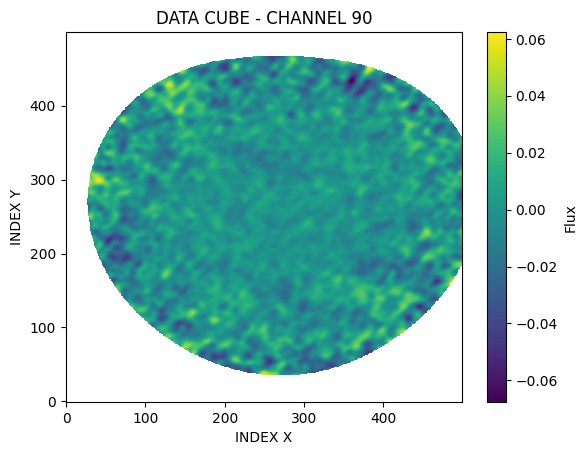

In [ ]:
channel_index = 90
plt.imshow(cube_data[channel_index], origin='lower', cmap='viridis', aspect='auto')

#set labels
plt.xlabel('INDEX X')
plt.ylabel('INDEX Y')
plt.title(f'DATA CUBE - CHANNEL {channel_index}')

#show the figure of cube
plt.colorbar(label='Flux')

Aquí podemos ver parte de la emisión originada desde la galaxia a la velocidad correspondiente en ese segmento.

Ahora usamos las aperturas creadas en ds9 como regiones, generamos un perfil para cada región y creamos un gráfico para cada una.

In [ ]:
from astropy.units.cgs import K

image_cube = '/content/drive/MyDrive/Imaging Codes/Galaxyfits/NGC_5258_cube_1arcsec_inregion.pbcor_hcorr.fits'
vla_cube = fits.getdata(image_cube)

region_cube = pathd + 'Regions/guide_2Dimage'
region1 = pyregion.open(region_cube)
region1

[Shape : circle ( Number(167),Number(320),Number(20) ),
 Shape : circle ( Number(360),Number(125),Number(20) ),
 Shape : circle ( Number(342),Number(160),Number(20) ),
 Shape : circle ( Number(249),Number(224),Number(20) ),
 Shape : circle ( Number(305),Number(210),Number(20) ),
 Shape : circle ( Number(188),Number(265),Number(20) ),
 Shape : circle ( Number(164),Number(385),Number(20) )]

## Líneas de emisión

Extrayendo información del encabezado sobre la frecuencia

In [ ]:
frequency = cube_header['CRVAL3'] + (np.arange(cube_header['NAXIS3']) - cube_header['CRPIX3'] + 1) * cube_header['CDELT3']

Coordenadas de regiones

In [ ]:
x, y, radius = 167, 320, 20

x1,y1,radius1= 360, 125, 20

x2,y2,radius2= 342, 160, 20

x3,y3,radius3= 249,224,20

x4,y4,radius4= 305,210,20

x5,y5,radius5= 188,265,20

x6,y6,radius6= 164,385,20

Definiendo funciones para crear una máscara circular, calcular las líneas de emisión y graficarla.

In [ ]:
def generate_circular_mask(shape, center_x, center_y, radius):
    y, x = np.ogrid[:shape[0], :shape[1]]
    masko = (x - center_x)**2 + (y - center_y)**2 <= radius**2
    return masko

def calculate_emission_line(masko):
    spectrum = np.nanmean(vla_cube[:, masko], axis=1)
    return frequency, spectrum

def plot_emission_line(region, frequency, spectrum):
    plt.figure(figsize=(8, 5))
    plt.plot(frequency, spectrum, label='Region {}'.format(region))
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Flux Density (K)')
    plt.title('Emission Line Profile for {}'.format(region))
    plt.legend()
    plt.grid()
    plt.show()

Generando la máscara para la región de interés

In [ ]:
masko = generate_circular_mask(vla_cube.shape[1:], x, y, radius)
masko1 = generate_circular_mask(vla_cube.shape[1:], x1, y1, radius1)
masko2= generate_circular_mask(vla_cube.shape[1:], x2, y2, radius2)
masko3 = generate_circular_mask(vla_cube.shape[1:], x3, y3, radius3)
masko4 = generate_circular_mask(vla_cube.shape[1:], x4, y4, radius4)
masko5 = generate_circular_mask(vla_cube.shape[1:], x5, y5, radius5)
masko6 = generate_circular_mask(vla_cube.shape[1:], x6, y6, radius6)

Calculando y graficando la línea de emisión para la región de interés.

ValueError: x and y must have same first dimension, but have shapes (450,) and (250,)

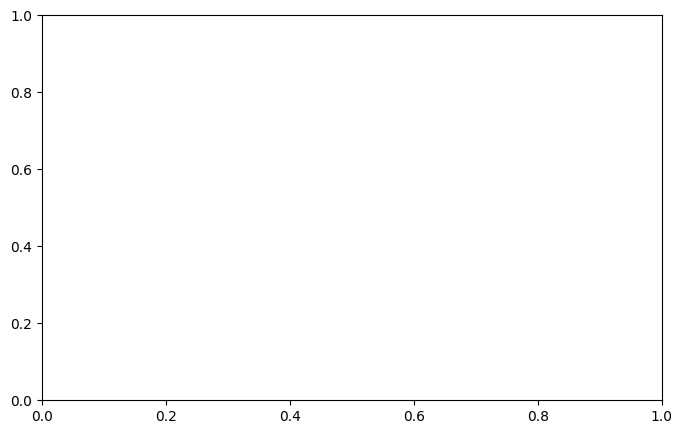

In [ ]:
frequency, spectrum = calculate_emission_line(masko)
plot_emission_line('Region 1', frequency, spectrum)

frequency, spectrum = calculate_emission_line(masko1)
plot_emission_line('Region 2', frequency, spectrum)

frequency, spectrum = calculate_emission_line(masko2)
plot_emission_line('Region 3', frequency, spectrum)

frequency, spectrum = calculate_emission_line(masko3)
plot_emission_line('Region 4', frequency, spectrum)

frequency, spectrum = calculate_emission_line(masko4)
plot_emission_line('Region 5', frequency, spectrum)

frequency, spectrum = calculate_emission_line(masko5)
plot_emission_line('Region 6', frequency, spectrum)

frequency, spectrum = calculate_emission_line(masko6)
plot_emission_line('Region 7', frequency, spectrum)

## Moment Maps


Creando una función para calcular el rms

In [ ]:
def rms_function(array):
    N = len(array)
    rms = np.sqrt(np.sum(array**2)/N)
    return rms

Creando una función para hacer el recorte (clipping)

In [ ]:
def clipper(array,rms, pb_mask):
    clipped_array = np.zeros([array.shape[0],array.shape[1],array.shape[2]])
    for k in range(0,array.shape[0],1):
        array[k,:,:] = np.multiply(pb_mask,array[k,:,:])
        for i in range(0,array.shape[1],1):
            for j in range(0,array.shape[2],1):
                if array[k,i,j] >= rms:
                    clipped_array[k,i,j] = array[k,i,j]
                else:
                    clipped_array[k,i,j] = 0
    return clipped_array

Creando una función que devuelva los momentos

In [ ]:
def moments(cube,factor, pb_mask):
    cube_data    = cube.data
    header       = cube.header
    cube_data    = np.nan_to_num(cube_data)
    del header['HISTORY']

    v = cube_data.shape[0]
    x = cube_data.shape[1]
    y = cube_data.shape[2]
    V_d        = (1-header['CRVAL3']/header['RESTFRQ'])*2.99999e5                                         #converts central freq to velocity
    V_u        = (1-(header['CRVAL3']+header['CDELT3']*header['NAXIS3'])/header['RESTFRQ'])*2.99999e5     # calculates the lower frequency
    deltaV     = (V_u-V_d)/header['NAXIS3']

    slice_1    = cube_data[4,:,:]
    slice_2    = cube_data[-4,:,:]

    # npixels =

    rms        = 0.5*(rms_function(slice_1)+rms_function(slice_2))    #correct dividing by no of pixels in a beam

    cube_data  = clipper(cube_data,factor*0.008,pb_mask)

    v_axis     = np.linspace(0,v-1,v,dtype=int)
    M0   = np.zeros([x,y])
    M1   = np.zeros([x,y])
    M2   = np.zeros([x,y])
    vl   = np.linspace(V_d,V_u,v)
    for i in range(0,x,1):
        for j in range(0,y,1):
            M0[i,j] = scipy.integrate.simps(cube_data[:,i,j],v_axis)*deltaV
            M1[i,j] = (scipy.integrate.simps(vl*cube_data[:,i,j],v_axis)*deltaV)/M0[i,j]
            M2[i,j] = np.sqrt((scipy.integrate.simps(cube_data[:,i,j]*(vl-M1[i,j])**2,v_axis)*deltaV)/M0[i,j])


    new_header          = header
    new_header['NAXIS'] = 2
    del new_header['NAXIS3']
    del new_header['CTYPE3']
    del new_header['CRVAL3']
    del new_header['CDELT3']
    del new_header['CRPIX3']
    del new_header['CUNIT3']
    del new_header['PC4_1']
    del new_header['PC4_2']
    del new_header['PC1_4']
    del new_header['PC2_4']
    del new_header['PC4_4']

    mom_0 = fits.PrimaryHDU(M0.astype('float'), new_header)
    mom_1 = fits.PrimaryHDU(M1.astype('float'), new_header)
    mom_2 = fits.PrimaryHDU(M2.astype('float'), new_header)
    return mom_0,mom_1,mom_2

Creando una máscara alrededor de la galaxia para eliminar los bordes ruidosos.

In [ ]:
import pyregion
a = """image \npolygon({},{},{},{},{},{},{},{},{},{},{},{},{},{})""".format(72,379, 72,212,228,8,452 ,8, 452,245, 215,489,121,489 )
region = []
region.append(a)
r = pyregion.parse(region[0])
envelope_mask      = r.get_mask(shape=[500, 500])

Cálculo de los momentos a partir del archivo FITS

In [ ]:
import scipy as sp
import scipy.ndimage
cube         = fits.open('/content/drive/MyDrive/Imaging Codes/Galaxyfits/NGC_5258_cube_1arcsec_inregion.pbcor_hcorr.fits')[0]
moment_0, moment_1, moment_2 = moments(cube,5,envelope_mask)

Graficando los momentos

In [ ]:
fig = aplpy.FITSFigure(moment_0, figsize=(10, 10))
fig.set_title('Moment 0',fontsize=20)
fig.show_colorscale(cmap='viridis')
fig.add_colorbar()
fig.colorbar.set_location('right')
fig.colorbar.set_width(0.3)
fig.colorbar.set_font(size='25')
fig.colorbar.set_axis_label_text('Intensity [Jy/beam kms] ')
fig.colorbar.set_axis_label_font(size=25)
fig.axis_labels.set_font(size=20)
fig.tick_labels.set_font(size=20)
fig.ticks.set_length(10)
fig.add_beam()
fig.beam.set_color('black')

In [ ]:
fig = aplpy.FITSFigure(moment_1, figsize=(10, 10))
fig.set_title('Moment 1',fontsize=20)
fig.show_colorscale(cmap='viridis',vmin=6000,vmax = 6300)
fig.add_colorbar()
fig.colorbar.set_location('right')
fig.colorbar.set_width(0.3)
fig.colorbar.set_font(size='25')
fig.colorbar.set_axis_label_text('Moment 1 ')
fig.colorbar.set_axis_label_font(size=25)
fig.axis_labels.set_font(size=20)
fig.tick_labels.set_font(size=20)
fig.ticks.set_length(10)
fig.add_beam()
fig.beam.set_color('black')

In [ ]:
fig = aplpy.FITSFigure(moment_2, figsize=(10, 10))
fig.set_title('Moment 2',fontsize=20)
fig.show_colorscale(cmap='viridis',vmin=0,vmax = 40)
fig.add_colorbar()
fig.colorbar.set_location('right')
fig.colorbar.set_width(0.3)
fig.colorbar.set_font(size='25')
fig.colorbar.set_axis_label_text('Moment 2 ')
fig.colorbar.set_axis_label_font(size=25)
fig.axis_labels.set_font(size=20)
fig.tick_labels.set_font(size=20)
fig.ticks.set_length(10)
fig.add_beam()
fig.beam.set_color('black')